In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import datetime as dt
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import yfinance as yf 

from pypfopt import (expected_returns, risk_models, plotting, EfficientFrontier, 
                     DiscreteAllocation, get_latest_prices, objective_functions,
                     EfficientSemivariance, EfficientCVaR, EfficientCDaR, CLA)

plt.style.use('bmh')

# Expected Returns and Risk Models

## Get data

In [3]:
tickers = ['^GSPC', '^N225', '^FTSE', '^GDAXI', '^SET.BK']
data = yf.download(tickers=tickers, period='10y', interval='1d', auto_adjust=True).Close
data.rename(columns={'^FTSE':'FTSE 100 Index', 
                     '^GDAXI':'DAX PERFORMANCE-INDEX',
                     '^GSPC':'S&P 500',
                     '^N225':'Nikkei 225',
                     '^SET.BK':'SET Index'}, 
            inplace=True)
data

[*********************100%***********************]  5 of 5 completed


,FTSE 100 Index,DAX PERFORMANCE-INDEX,S&P 500,Nikkei 225,SET Index
Date,,,,,
2012-05-02,NaN,NaN,NaN,9380.250000,NaN
2012-05-03,5766.600098,6694.439941,1391.569946,NaN,1240.030029
2012-05-04,5655.100098,6561.470215,1369.099976,NaN,1227.410034
2012-05-07,NaN,6569.479980,1369.579956,9119.139648,NaN
2012-05-08,5554.600098,6444.740234,1363.719971,9181.650391,1231.040039
...,...,...,...,...,...
2022-04-27,7425.600098,13793.940430,4183.959961,26386.630859,1661.890015
2022-04-28,7509.200195,13979.839844,4287.500000,26847.900391,1667.739990
2022-04-29,7544.600098,14097.879883,4131.930176,NaN,1667.439941


In [4]:
# splitting data
test_size = 0.3
train_len = int(len(data)*(1-test_size))
in_sample_data = data.iloc[:train_len]
out_sample_data = data.iloc[train_len:]

In [5]:
print(f'In-sample data length: {len(in_sample_data)}')
print(f'Out-sample data length: {len(out_sample_data)}')

In-sample data length: 1821
Out-sample data length: 781


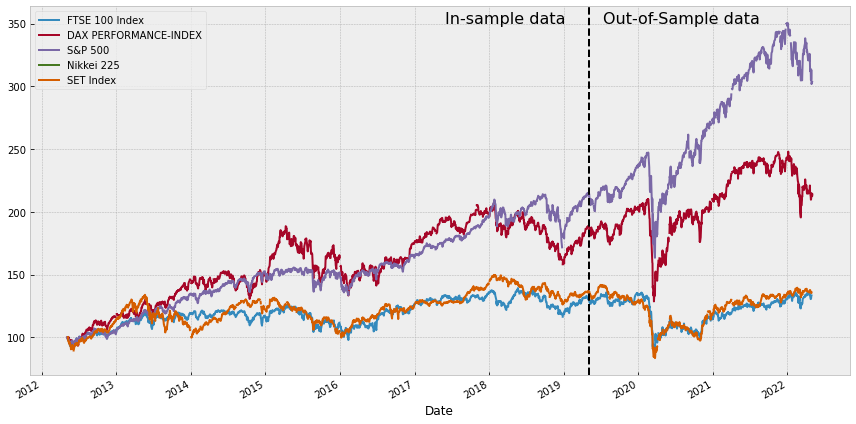

In [6]:
data_rebased = (data.iloc[2:]/data.iloc[2]) * 100
fig, ax = plt.subplots(figsize=(12, 6))

data_rebased.plot(ax=ax)
ax.axvline(x=out_sample_data.index[0], color='k', linestyle='--')
ax.annotate("In-sample data", (in_sample_data.index[-500], data_rebased.max().max()),fontsize=16)
ax.annotate("Out-of-Sample data", (out_sample_data.index[50], data_rebased.max().max()),fontsize=16)

plt.tight_layout()
plt.show()

## Risk Models

In [7]:
in_sample_cov = risk_models.sample_cov(in_sample_data)
out_sample_cov = risk_models.sample_cov(out_sample_data)

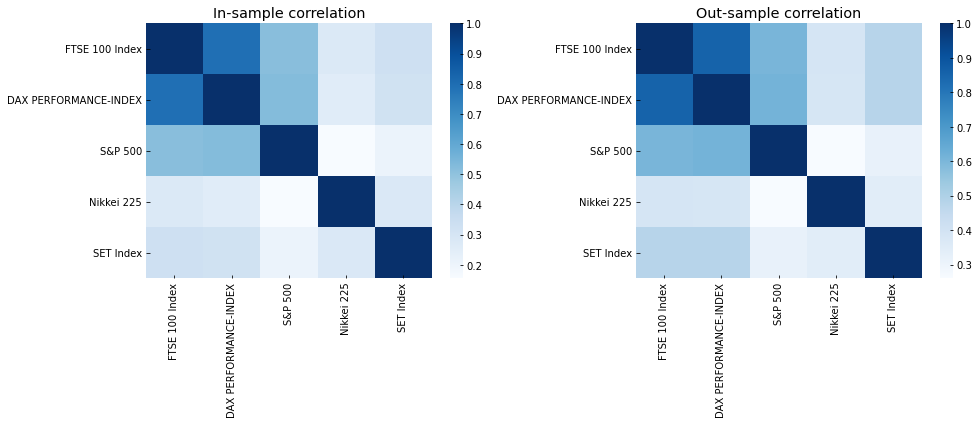

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

sns.heatmap(risk_models.cov_to_corr(in_sample_cov), ax=ax[0], cmap='Blues')
ax[0].set_title('In-sample correlation')

sns.heatmap(risk_models.cov_to_corr(out_sample_cov), ax=ax[1], cmap='Blues')
ax[1].set_title('Out-sample correlation')

plt.tight_layout()
plt.show()

In [9]:
in_sample_var = np.diag(in_sample_cov)
out_sample_var = np.diag(out_sample_cov)

In [10]:
in_sample_var_df = pd.DataFrame(data=in_sample_var, index=in_sample_cov.index, columns=['Variance'])
in_sample_var_df['data'] = 'in-sample'
in_sample_var_df

out_sample_var_df = pd.DataFrame(data=out_sample_var, index=out_sample_cov.index, columns=['Variance'])
out_sample_var_df['data'] = 'out-sample'
out_sample_var_df

var_df = pd.concat([in_sample_var_df, out_sample_var_df])
var_df.sort_values(by='Variance', ascending=False, inplace=True)

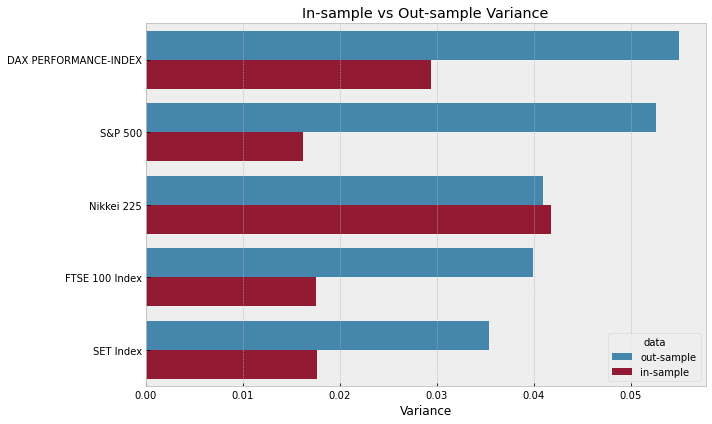

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=var_df, x='Variance', y=var_df.index, hue='data', ax=ax)
ax.set_title('In-sample vs Out-sample Variance')
plt.tight_layout()
plt.show()

In [12]:
risk_methods = ["sample_cov",
                "semicovariance",
                "exp_cov",
                "ledoit_wolf_constant_variance",
                "ledoit_wolf_single_factor",
                "ledoit_wolf_constant_correlation",
                "oracle_approximating"]

rmses = {}
maes = {}
for method in risk_methods:
    # estimate covariance
    est_cov = risk_models.risk_matrix(in_sample_data, method=method)
    est_var = np.diag(est_cov)

    # RMSE 
    rmse = np.sqrt(np.mean((out_sample_var - est_var)**2))
    rmses[method] = rmse
    
    # MAE
    mae = np.mean(np.abs(out_sample_var - est_var))
    maes[method] = mae

In [13]:
rmse_df = pd.DataFrame.from_dict(rmses, orient='index', columns=['error'])
rmse_df['type'] = 'RMSE'

mae_df = pd.DataFrame.from_dict(maes, orient='index', columns=['error'])
mae_df['type'] = 'MAE'

errors_df = pd.concat([rmse_df, mae_df])
errors_df.sort_values(by='error', inplace=True)

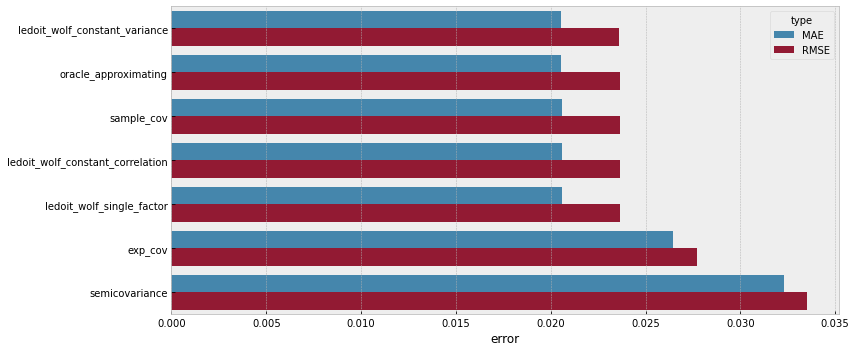

In [14]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(data=errors_df, y=errors_df.index, x='error', hue='type', ax=ax)
plt.tight_layout()
plt.show()

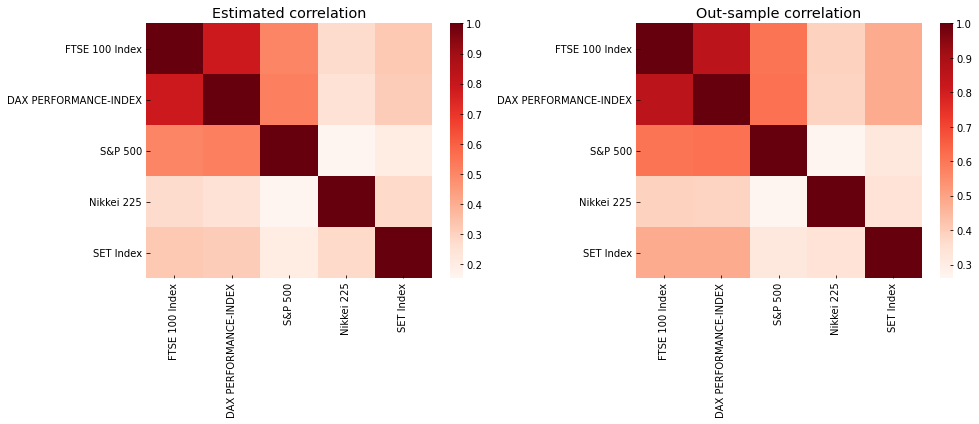

In [15]:
semi_cov = risk_models.risk_matrix(in_sample_data, method="ledoit_wolf_constant_variance")

fig, ax = plt.subplots(1, 2, figsize=(14,6))

sns.heatmap(risk_models.cov_to_corr(semi_cov), ax=ax[0], cmap='Reds')
ax[0].set_title('Estimated correlation')

sns.heatmap(risk_models.cov_to_corr(out_sample_cov), ax=ax[1], cmap='Reds')
ax[1].set_title('Out-sample correlation')

plt.tight_layout()
plt.show()

In [16]:
estimated_variance = pd.DataFrame()

for method in risk_methods:
    var = risk_models.risk_matrix(in_sample_data, method=method)
    var_df = pd.DataFrame(data=np.diag(var), index=var.index, columns=['Variance'])
    var_df['method'] = method
    estimated_variance = pd.concat([estimated_variance, var_df], axis=0)
    
out_sample_var_df = pd.DataFrame(data=np.diag(out_sample_cov), index=out_sample_cov.index, columns=['Variance'])
out_sample_var_df['method'] = 'Out-of-sample'
estimated_variance = pd.concat([estimated_variance, out_sample_var_df], axis=0)

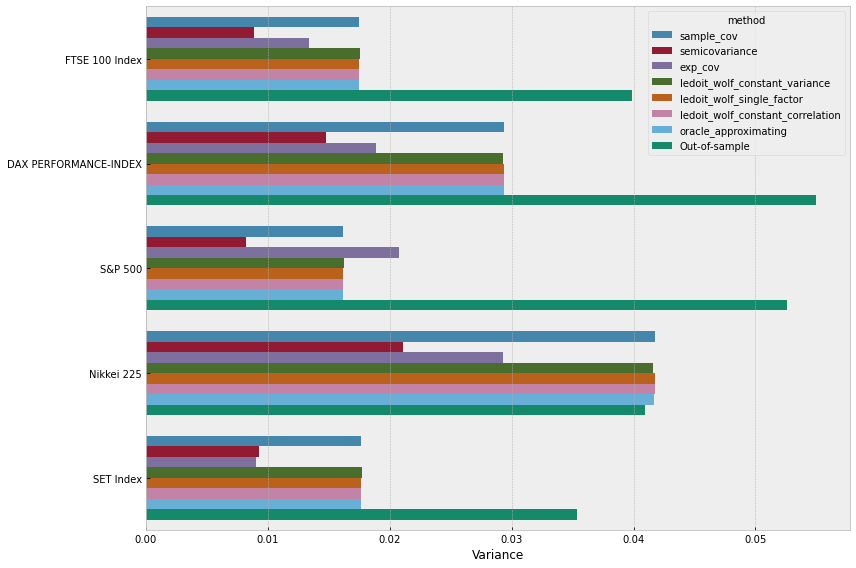

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=estimated_variance, x='Variance', y=estimated_variance.index, hue='method', ax=ax)
plt.tight_layout()
plt.show()

## Expected Returns

In [18]:
out_sample_return = expected_returns.mean_historical_return(out_sample_data)
out_sample_return

FTSE 100 Index           0.006028
DAX PERFORMANCE-INDEX    0.040383
S&P 500                  0.117578
Nikkei 225               0.067453
SET Index               -0.004235
dtype: float64

In [19]:
return_methods = ['mean_historical_return',
                  'ema_historical_return',
                  'capm_return']

rmses = {}
maes = {}
for method in return_methods:
    est_ret = expected_returns.return_model(in_sample_data, method=method)
    
    # RMSE
    rmse = np.sqrt(np.mean((est_ret - out_sample_return)**2))
    rmses[method] = rmse
    
    # MAE
    mae = np.mean(np.abs(est_ret - out_sample_return))
    maes[method] = mae

In [20]:
rmse_df = pd.DataFrame.from_dict(rmses, orient='index', columns=['error'])
rmse_df['type'] = 'RMSE'

mae_df = pd.DataFrame.from_dict(maes, orient='index', columns=['error'])
mae_df['type'] = 'MAE'

errors_df = pd.concat([rmse_df, mae_df])
errors_df.sort_values(by='error', inplace=True)

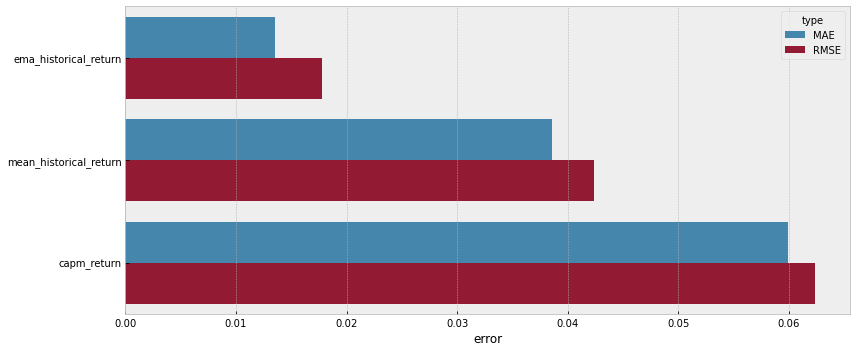

In [21]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(data=errors_df, y=errors_df.index, x='error', hue='type', ax=ax)
plt.tight_layout()
plt.show()

In [22]:
estimated_returns = pd.DataFrame()

for method in return_methods:
    est_ret = expected_returns.return_model(in_sample_data, method=method)
    est_ret = est_ret.to_frame()
    est_ret.columns = ['Returns']
    est_ret['method'] = method
    estimated_returns = pd.concat([estimated_returns, est_ret], axis=0)
    
out_sample_return_df = out_sample_return.to_frame()
out_sample_return_df.columns = ['Returns']
out_sample_return_df['method'] = 'Out-of-sample'
out_sample_return_df
estimated_returns = pd.concat([estimated_returns, out_sample_return_df], axis=0)

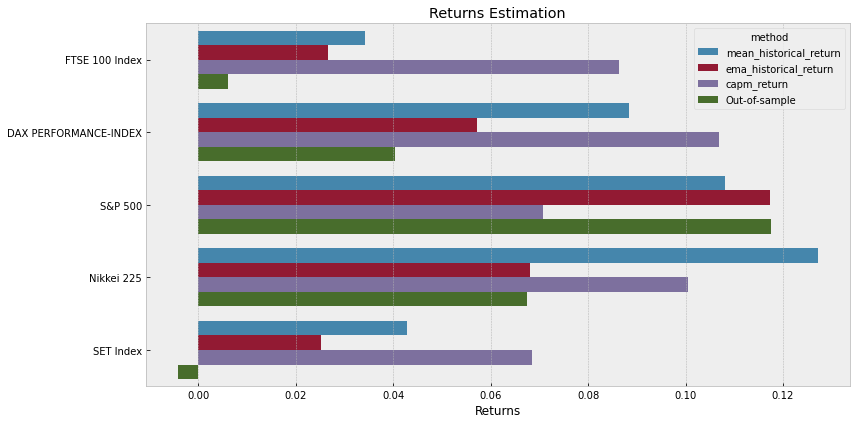

In [23]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=estimated_returns, y=estimated_returns.index, x='Returns', hue='method', ax=ax)
ax.set_title('Returns Estimation')
plt.tight_layout()
plt.show()

# Mean-Variance Optimization

## Get data

In [24]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 
           'BRK-A', 'FB', 'UNH', 'JNJ', 'V',
           'NVDA', 'WMT', 'PG', 'XOM', 'JPM']

In [25]:
data = yf.download(tickers=tickers, period='10y', interval='1d')['Adj Close']
print(data.shape)
data.head()

[*********************100%***********************]  15 of 15 completed
(2516, 15)


,AAPL,AMZN,BRK-A,FB,GOOG,JNJ,JPM,MSFT,NVDA,PG,TSLA,UNH,V,WMT,XOM
Date,,,,,,,,,,,,,,,
2012-05-03,17.792763,229.449997,121800.0,NaN,304.369141,49.372719,32.655361,25.822626,2.900018,47.958630,6.492,47.686649,27.141203,46.964581,56.546886
2012-05-04,17.286032,223.990005,121950.0,NaN,297.370392,48.919353,31.698721,25.188448,2.815061,47.787651,6.366,46.830822,27.462954,46.733700,55.833847
2012-05-07,17.415394,225.160004,123676.0,NaN,302.640625,48.964684,31.721481,24.920135,2.863281,47.765354,6.494,47.284412,27.630823,47.123810,55.774429
2012-05-08,17.375639,223.899994,123744.0,NaN,305.250854,49.100708,31.417786,24.798183,2.860984,47.698433,6.038,47.772236,27.544558,47.012333,55.470734
2012-05-09,17.406223,222.979996,122560.0,NaN,303.437653,48.571751,30.855942,25.009581,2.872465,47.334160,6.012,47.258743,27.376686,47.315331,55.001991


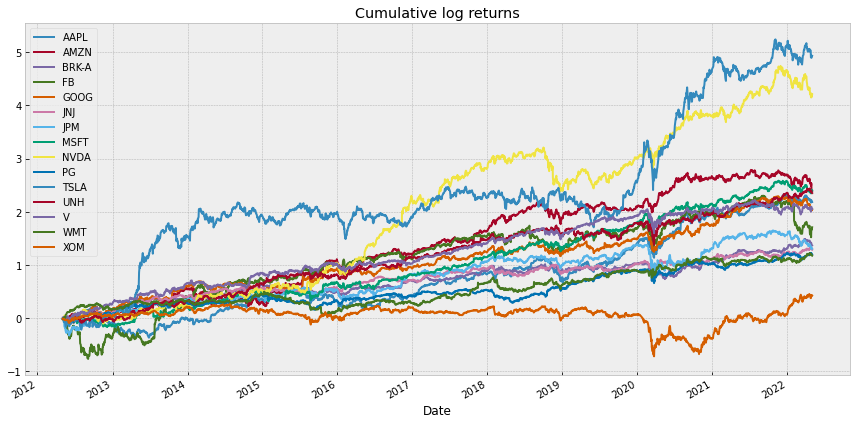

In [26]:
data.apply(np.log).diff(1).cumsum().plot(figsize=(12,6))
plt.title("Cumulative log returns")
plt.tight_layout()
plt.show()

## calculate Covariance matrix

In [27]:
S = risk_models.CovarianceShrinkage(data, frequency=252).ledoit_wolf()

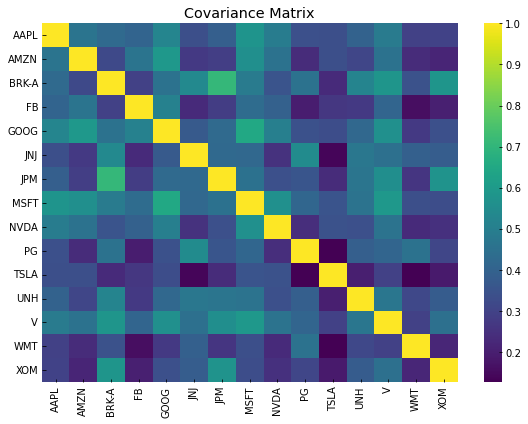

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(risk_models.cov_to_corr(S), cmap='viridis')
plt.title("Covariance Matrix")
plt.tight_layout()
plt.show()

## Return estimation

In [29]:
mu = expected_returns.ema_historical_return(data, frequency=252)
mu 

AAPL     0.311660
AMZN    -0.097726
BRK-A    0.210900
FB      -0.106227
GOOG     0.112283
JNJ      0.158620
JPM     -0.059051
MSFT     0.209319
NVDA     0.380769
PG       0.195166
TSLA     1.033958
UNH      0.345521
V        0.074646
WMT      0.153565
XOM      0.559655
Name: 2022-05-02 00:00:00, dtype: float64

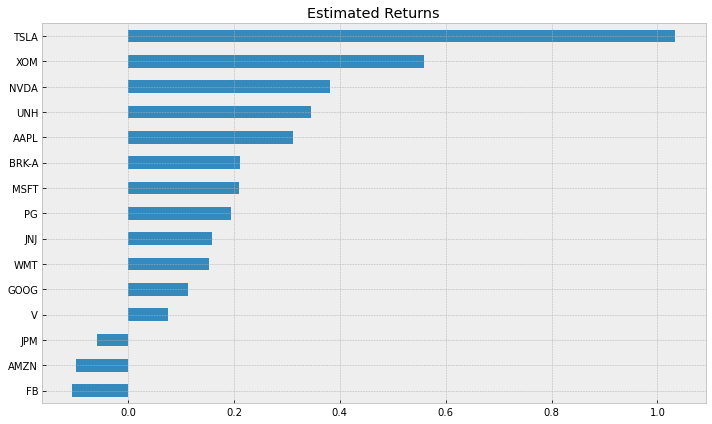

In [30]:
mu.sort_values().plot(kind='barh', figsize=(10,6))
plt.title("Estimated Returns")
plt.tight_layout()
plt.show()

## Long/Short Min Variance
* There is a good deal of research that demonstrates that these global-minimum variance (GMV) portfolios outperform mean-variance optimized portfolios.

In [31]:
# min_volatility --> Don't have to provide returns

ef = EfficientFrontier(expected_returns=None, 
                       cov_matrix=S, 
                       weight_bounds=(None,None))

In [32]:
ef.min_volatility()

OrderedDict([('AAPL', 0.0146792391229308),
             ('AMZN', 0.0550366645614276),
             ('BRK-A', 0.2900814514102289),
             ('FB', 0.0203478933519462),
             ('GOOG', 0.0403047843389505),
             ('JNJ', 0.2314778390792898),
             ('JPM', -0.0789575529565857),
             ('MSFT', -0.0425717899583187),
             ('NVDA', -0.0262338859183619),
             ('PG', 0.2261057672533154),
             ('TSLA', 0.0073405515500726),
             ('UNH', -0.0010648121965083),
             ('V', -0.020632969556015),
             ('WMT', 0.2207327110284453),
             ('XOM', 0.0633541088891826)])

In [33]:
for a, w in ef.clean_weights().items():
    print(f"{a:5s} --> {str(round((w*100),2)):>5s} %")

total_weight = np.sum(list(ef.clean_weights().values()))
print("-"*20)
print(f"Total {str(total_weight*100)} %")
print("="*20)

AAPL  -->  1.47 %
AMZN  -->   5.5 %
BRK-A --> 29.01 %
FB    -->  2.04 %
GOOG  -->  4.03 %
JNJ   --> 23.15 %
JPM   -->  -7.9 %
MSFT  --> -4.26 %
NVDA  --> -2.62 %
PG    --> 22.61 %
TSLA  -->  0.73 %
UNH   --> -0.11 %
V     --> -2.06 %
WMT   --> 22.07 %
XOM   -->  6.34 %
--------------------
Total 100.001 %


In [34]:
weights = pd.Series(ef.clean_weights()).sort_values()

In [35]:
new_ticks = []
for a, w in zip(weights.index.values, weights.values):
    new_ticks.append(f"{a}  {w*100:.2f} %")

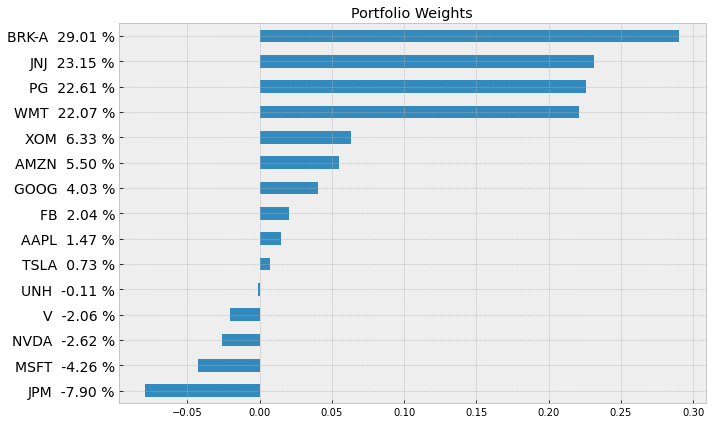

In [36]:
ax = weights.plot(kind='barh', figsize=(10,6))
ax.set_yticks(range(len(new_ticks)), new_ticks, fontsize=14)
ax.set_title("Portfolio Weights")
plt.tight_layout()
plt.show()

In [37]:
ef.portfolio_performance(verbose=True)

Annual volatility: 13.7%


(None, 0.13727410775843937, None)

In [38]:
# discrete allocation

last_prices = get_latest_prices(data)
last_prices

AAPL        157.960007
AMZN       2490.000000
BRK-A    478150.000000
FB          211.130005
GOOG       2343.139893
JNJ         178.639999
JPM         120.449997
MSFT        284.470001
NVDA        195.330002
PG          158.380005
TSLA        902.940002
UNH         501.149994
V           211.529999
WMT         151.979996
XOM          86.410004
Name: 2022-05-02 00:00:00, dtype: float64

portfolio \$10000, short ratio = 0.3 --> 130/30 long-short balance<br>
* long \$10000 
* short \$3000
* use proceed $3000 to long
* Total value of Portfolio = \$13,000

In [39]:
da = DiscreteAllocation(ef.clean_weights(), last_prices,total_portfolio_value=10000000, short_ratio=0.5)
allocation, leftover = da.lp_portfolio()

In [40]:
position_values = {}
for a, s in allocation.items():
    position_values[a] = abs(s * last_prices[a])

In [41]:
for a, s in allocation.items():
    pos_val = position_values[a]
    print(f"{a:5s} --> {str(s):>6s} shares --> $ {pos_val:,.2f} ")
print("-"*50)
print(f"Leftover --> $ {leftover:,.2f}")
print("-"*50)
total_val = np.sum(list(position_values.values())) + leftover
print(f"Total Portfolio Value --> $ {total_val:,}")
print("="*50)

AAPL  -->    795 shares --> $ 125,578.21 
AMZN  -->    190 shares --> $ 473,100.00 
BRK-A -->      5 shares --> $ 2,390,750.00 
FB    -->    825 shares --> $ 174,182.25 
GOOG  -->    148 shares --> $ 346,784.70 
JNJ   -->  11081 shares --> $ 1,979,509.83 
PG    -->  12208 shares --> $ 1,933,503.10 
TSLA  -->     70 shares --> $ 63,205.80 
WMT   -->  12420 shares --> $ 1,887,591.55 
XOM   -->   6269 shares --> $ 541,704.31 
JPM   --> -19344 shares --> $ 2,329,984.74 
MSFT  -->  -4416 shares --> $ 1,256,219.53 
NVDA  -->  -3962 shares --> $ 773,897.47 
UNH   -->    -62 shares --> $ 31,071.30 
V     -->  -2878 shares --> $ 608,783.34 
--------------------------------------------------
Leftover --> $ 84,133.87
--------------------------------------------------
Total Portfolio Value --> $ 15,000,000.0


## Sector / Individual constraints

In [42]:
sector_mapper = {
    "AAPL": "Technology",
    "AMZN": "Consumer Cyclical",
    "BRK-A": "Financial Services",
    "FB": "Communication Services",
    "GOOG": "Communication Services",
    "JNJ": "Healthcare",
    "JPM": "Financial Services",
    "MSFT": "Technology",
    "NVDA": "Technology",
    "PG": "Consumer Defensive",
    "TSLA": "Consumer Cyclical",
    "UNH": "Healthcare",
    "V": "Financial Services",
    "WMT": "Consumer Defensive",
    "XOM": "Energy"
}

In [43]:
# sector_mapper = {}
# d0 = dt.datetime.now()
# for ticker in tickers:
#     dt_ticker = dt.datetime.now()
#     company = yf.Ticker(ticker)
#     sector_mapper[ticker] = company.info['sector']
#     print(f"{ticker:5s} --> {dt.datetime.now()-dt_ticker}")
# print('-'*30)
# print(f"Total time: {dt.datetime.now()-d0}")

In [44]:
sector_mapper

{'AAPL': 'Technology',
 'AMZN': 'Consumer Cyclical',
 'BRK-A': 'Financial Services',
 'FB': 'Communication Services',
 'GOOG': 'Communication Services',
 'JNJ': 'Healthcare',
 'JPM': 'Financial Services',
 'MSFT': 'Technology',
 'NVDA': 'Technology',
 'PG': 'Consumer Defensive',
 'TSLA': 'Consumer Cyclical',
 'UNH': 'Healthcare',
 'V': 'Financial Services',
 'WMT': 'Consumer Defensive',
 'XOM': 'Energy'}

In [45]:
# Add sectors contraints

# set lower bound to each sectors
sector_lower = {
    "Technology": 0.3, # at least 20% to tech
    "Consumer Defensive": 0.05, # at least 5% to consumer defensive
    "Financial Services": 0.05, # at least 5% to financial services
    "Communication Services": 0.1 # at least 10% to communication services
}

# set upper bounds to each sectors
sector_upper = {
    "Technology": 0.8, # at most 80% to tech
    "Financial Services": 0.6, # at most 60% to financial services
    "Healthcare": 0.5, # at most 50% to health care
    "Energy": 0.4 # at most 40% to energy
}

In [46]:
mu = expected_returns.ema_historical_return(data)
S = risk_models.CovarianceShrinkage(data).ledoit_wolf()

In [47]:
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

In [48]:
# Add individual stocks constraint

# set AMZN to 10%
amzn_idx = data.columns.get_loc('AMZN')
ef.add_constraint(lambda w: w[amzn_idx] == 0.1) 

# set AAPL less than 30%
aapl_idx = data.columns.get_loc('AAPL')
ef.add_constraint(lambda w: w[aapl_idx] <= 0.3)

# constrain W(GOOG) == 1.5*W(FB) --> not working with max_sharpe
fb_idx = data.columns.get_loc('FB')
goog_idx = data.columns.get_loc('GOOG')
ef.add_constraint(lambda w: w[goog_idx] == 1.5*w[fb_idx])

# set NVDA >= TSLA
nvda_idx = data.columns.get_loc('NVDA')
tsla_idx = data.columns.get_loc('TSLA')
ef.add_constraint(lambda w: w[nvda_idx] >= w[tsla_idx])

In [49]:
ef.min_volatility()

OrderedDict([('AAPL', 0.1442365670950386),
             ('AMZN', 0.1000000020759166),
             ('BRK-A', 0.0500339178512759),
             ('FB', 0.0400009834792466),
             ('GOOG', 0.060001475234823),
             ('JNJ', 0.1503007261071274),
             ('JPM', -1.0701247623e-05),
             ('MSFT', 0.155766728119017),
             ('NVDA', -2.454549425e-07),
             ('PG', 0.1383046273655148),
             ('TSLA', 5.026908266e-07),
             ('UNH', 2.1011424995e-06),
             ('V', -1.09432218864e-05),
             ('WMT', 0.1504808594361067),
             ('XOM', 0.0108933977938864)])

In [50]:
sector_weights = {}
for a, w in ef.clean_weights().items():
    print(f"{a:7s} {str(round((w*100),2)):>5s} %")
    sector = sector_mapper[a]
    sector_weights[sector] = sector_weights.get(sector, 0) + w

total_weight = np.sum(list(ef.clean_weights().values()))
print("-"*20)
print(f"Total  {total_weight*100:.2f} %")
print("="*20)

AAPL    14.42 %
AMZN     10.0 %
BRK-A     5.0 %
FB        4.0 %
GOOG      6.0 %
JNJ     15.03 %
JPM       0.0 %
MSFT    15.58 %
NVDA      0.0 %
PG      13.83 %
TSLA      0.0 %
UNH       0.0 %
V         0.0 %
WMT     15.05 %
XOM      1.09 %
--------------------
Total  100.00 %


In [51]:
for s, w in sector_weights.items():
    print(f"{s:25s} {w*100:.2f} %")
print('-'*35)
total = "Total"
total_weight = np.sum(list(sector_weights.values()))
print(f"{total:25s} {total_weight*100:.2f}%")
print('='*35)

Technology                30.00 %
Consumer Cyclical         10.00 %
Financial Services        5.00 %
Communication Services    10.00 %
Healthcare                15.03 %
Consumer Defensive        28.88 %
Energy                    1.09 %
-----------------------------------
Total                     100.00%


In [52]:
ef.portfolio_performance(verbose=True)

Expected annual return: 16.1%
Annual volatility: 16.3%
Sharpe Ratio: 0.87


(0.1608645257966273, 0.16278022137984915, 0.865366348580634)

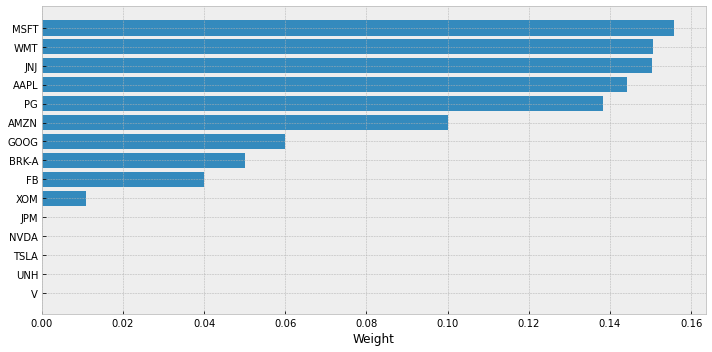

In [53]:
fig, ax = plt.subplots(figsize=(10,5))
plotting.plot_weights(ef.clean_weights(), ax=ax)
plt.tight_layout()
plt.show()

## Maximize return for a given risk, with L2 regularisation

### Target Volatility

In [54]:
# no more than 20% volatiliy --> maximize return
target_vol = 0.2
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.efficient_risk(target_volatility=target_vol)

OrderedDict([('AAPL', 0.2259716076987814),
             ('AMZN', 1.00619e-11),
             ('BRK-A', 0.0500000000386096),
             ('FB', 4.124e-11),
             ('GOOG', 0.0999999999773144),
             ('JNJ', 2.244798e-10),
             ('JPM', 1.55489e-11),
             ('MSFT', 0.0652522951641732),
             ('NVDA', 0.0087760971633367),
             ('PG', 0.0562640928856829),
             ('TSLA', 0.1125627725287066),
             ('UNH', 1.1555104e-09),
             ('V', 3.09091e-11),
             ('WMT', 0.0004623073914643),
             ('XOM', 0.3807108256739536)])

In [55]:
sector_weights = {}
for a, w in ef.clean_weights().items():
    sector = sector_mapper[a]
    sector_weights[sector] = sector_weights.get(sector, 0) + w

weights = pd.DataFrame.from_dict(ef.clean_weights(), orient='index', columns=['weights'])
weights['add obj'] = 'none'

sectors = pd.DataFrame.from_dict(sector_weights, orient='index', columns=['weights'])
sectors['add obj'] = 'none'

In [56]:
ef.portfolio_performance(verbose=True)

Expected annual return: 45.0%
Annual volatility: 20.0%
Sharpe Ratio: 2.15


(0.4497037385198216, 0.20000000005528784, 2.148518692005173)

### target volatiliy + L2-Regularization

In [57]:
# add L2 regularization --> alleviate 0% weight
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.add_objective(objective_functions.L2_reg, gamma=0.5)
ef.efficient_risk(target_volatility=target_vol)

OrderedDict([('AAPL', 0.1534978609490042),
             ('AMZN', 8.5486e-12),
             ('BRK-A', 0.0500000000963585),
             ('FB', 5.53527e-11),
             ('GOOG', 0.0999999999563914),
             ('JNJ', 0.0170698553437039),
             ('JPM', 1.29115e-11),
             ('MSFT', 0.0855665869609014),
             ('NVDA', 0.0609355521075434),
             ('PG', 0.0588493227607673),
             ('TSLA', 0.1453588409387561),
             ('UNH', 0.0623065870405999),
             ('V', 2.4742e-11),
             ('WMT', 0.0346346090418783),
             ('XOM', 0.2317807847025695)])

In [58]:
sector_weights = {}
for a, w in ef.clean_weights().items():
    sector = sector_mapper[a]
    sector_weights[sector] = sector_weights.get(sector, 0) + w

weights_l2 = pd.DataFrame.from_dict(ef.clean_weights(), orient='index', columns=['weights'])
weights_l2['add obj'] = 'L2 reg'

sectors_l2 = pd.DataFrame.from_dict(sector_weights, orient='index', columns=['weights'])
sectors_l2['add obj'] = 'L2 reg'

In [59]:
ef.portfolio_performance(verbose=True)

Expected annual return: 43.2%
Annual volatility: 20.0%
Sharpe Ratio: 2.06


(0.4317778742752307, 0.20000000001674265, 2.0588893712037972)

In [60]:
weights_combine = pd.concat([weights, weights_l2], axis=0).sort_values(by='weights', ascending=False)
sectors_combine = pd.concat([sectors, sectors_l2], axis=0).sort_values(by='weights', ascending=False)

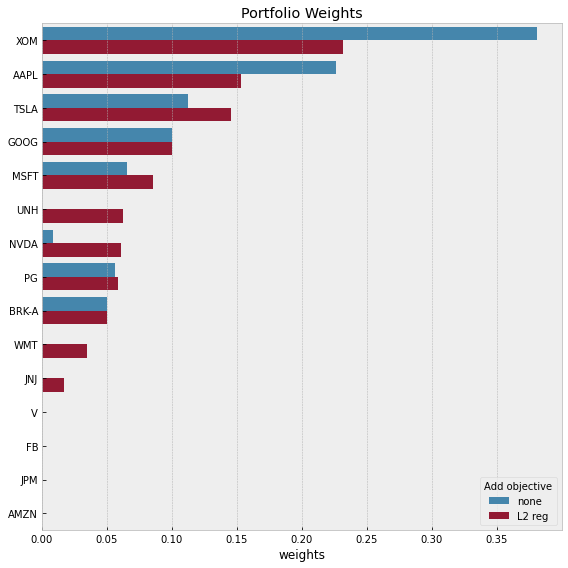

In [61]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(data=weights_combine, y=weights_combine.index, x='weights', hue='add obj', ax=ax)
ax.legend(loc='lower right', title='Add objective')
ax.set_title("Portfolio Weights")
plt.tight_layout()
plt.show()

## Minimize risk for a given return, market-neutral

In [62]:
# 7% target return --> mininize volatility
target_ret = 0.07
ef = EfficientFrontier(mu, S, weight_bounds=(None, None)) # allow shorts
ef.add_objective(objective_functions.L2_reg, gamma=0.5)
ef.efficient_return(target_return=target_ret, market_neutral=True) # market neutral

OrderedDict([('AAPL', 0.0063275120218545),
             ('AMZN', -0.0229535656164545),
             ('BRK-A', -0.0002599778189274),
             ('FB', -0.0214124861506574),
             ('GOOG', -0.0074167022931902),
             ('JNJ', -0.0038611010485443),
             ('JPM', -0.021183246939345),
             ('MSFT', -0.0007842839954763),
             ('NVDA', 0.0096422365262006),
             ('PG', -0.0010534249721334),
             ('TSLA', 0.0429013587977238),
             ('UNH', 0.0097205062988574),
             ('V', -0.0106419086181533),
             ('WMT', -0.0044235384308578),
             ('XOM', 0.0253986222391032)])

In [63]:
for a, w in ef.clean_weights().items():
    print(f"{a:7s} {str(round((w*100),2)):>5s} %")

total_weight = np.sum(list(ef.clean_weights().values()))
print("-"*20)
print(f"Total    {total_weight*100:.2f} %")
print("="*20)

AAPL     0.63 %
AMZN     -2.3 %
BRK-A   -0.03 %
FB      -2.14 %
GOOG    -0.74 %
JNJ     -0.39 %
JPM     -2.12 %
MSFT    -0.08 %
NVDA     0.96 %
PG       -0.1 %
TSLA     4.29 %
UNH      0.97 %
V       -1.06 %
WMT     -0.44 %
XOM      2.54 %
--------------------
Total    0.00 %


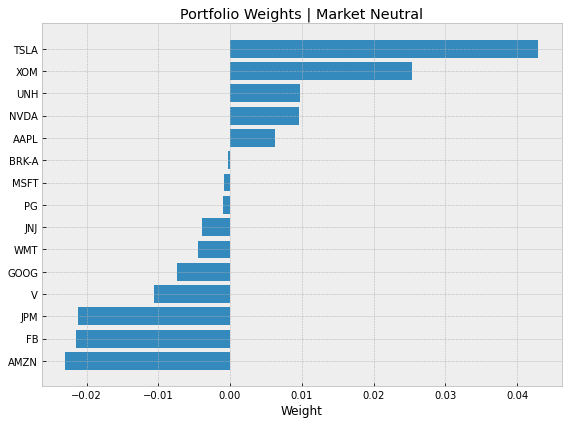

In [64]:
fig, ax = plt.subplots(figsize=(8,6))
plotting.plot_weights(ef.clean_weights(), ax=ax)
ax.set_title("Portfolio Weights | Market Neutral")
plt.tight_layout()
plt.show()

In [65]:
ef.portfolio_performance(verbose=True)

Expected annual return: 7.0%
Annual volatility: 2.5%
Sharpe Ratio: 2.04


(0.06999999999999998, 0.024517375978979794, 2.0393699571629504)

## Efficient semi-variance optimization

In [66]:
mu = expected_returns.ema_historical_return(data, frequency=252)
returns = expected_returns.returns_from_prices(data).dropna()

In [67]:
es = EfficientSemivariance(mu, returns)
es.efficient_return(0.2)

OrderedDict([('AAPL', 0.0028393172631102),
             ('AMZN', 0.0208699800537311),
             ('BRK-A', 0.2103472088141844),
             ('FB', 3.679018262e-07),
             ('GOOG', 1.99449312e-07),
             ('JNJ', 0.2095859317368706),
             ('JPM', 1.800643082e-07),
             ('MSFT', 1.17117174e-07),
             ('NVDA', 2.811730273e-07),
             ('PG', 0.2545955149226443),
             ('TSLA', 0.0096769014227664),
             ('UNH', 0.0063481622893004),
             ('V', 1.246542133e-07),
             ('WMT', 0.2419481760624611),
             ('XOM', 0.0437875371756019)])

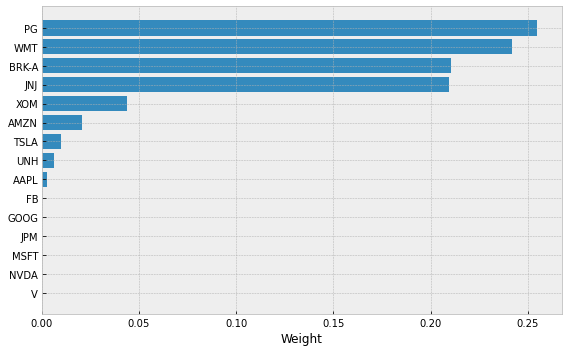

In [68]:
fig, ax = plt.subplots(figsize=(8,5))
plotting.plot_weights(es.clean_weights(), ax=ax)
plt.tight_layout()
plt.show()

In [69]:
es.portfolio_performance(verbose=True)

Expected annual return: 20.0%
Annual semi-deviation: 9.5%
Sortino Ratio: 1.89


(0.2000002852864875, 0.09527137807709346, 1.8893427272651766)

## Efficient CVaR optimization
* conditional value-at-risk (a.k.a expected shortfall)

In [70]:
mu = expected_returns.ema_historical_return(data)
returns = expected_returns.returns_from_prices(data).dropna()

In [71]:
ec = EfficientCVaR(mu, returns)
ec.min_cvar() # Min CVaR
ec.portfolio_performance(verbose=True)

Expected annual return: 16.2%
Conditional Value at Risk: 2.01%


(0.16242844771451403, 0.020061751632851822)

In [72]:
ec = EfficientCVaR(mu, returns)
ec.efficient_risk(target_cvar=0.025) # 2.5% CVaR is acceptable
ec.portfolio_performance(verbose=True)

Expected annual return: 44.8%
Conditional Value at Risk: 2.50%


(0.44779298129307293, 0.02500000000002585)

## Efficient CDaR
* conditional drawdown at risk (CDaR) 

In [73]:
mu = expected_returns.ema_historical_return(data, frequency=252)
returns = expected_returns.returns_from_prices(data).dropna()

In [74]:
ecd = EfficientCDaR(mu, returns)
ecd.min_cdar() # min CDaR
ecd.portfolio_performance(verbose=True)

Expected annual return: 11.3%
Conditional Drawdown at Risk: 8.83%


(0.11326268003960507, 0.08829200315450553)

In [75]:
ecd = EfficientCDaR(mu, returns)
ecd.efficient_risk(0.1) # 10% CDaR is acceptable
ecd.portfolio_performance(verbose=True)

Expected annual return: 26.1%
Conditional Drawdown at Risk: 10.00%


(0.26064289351517195, 0.10000000000000309)

## Plotting

### Plotting - Unconstrained
* easier to use Critical Line Algorithm (CLA)

In [76]:
mu = expected_returns.ema_historical_return(data)
S = risk_models.CovarianceShrinkage(data).ledoit_wolf()

In [77]:
cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose=True)

Expected annual return: 59.6%
Annual volatility: 22.3%
Sharpe Ratio: 2.59


(0.5962039311128768, 0.2226709163890646, 2.5876928179794128)

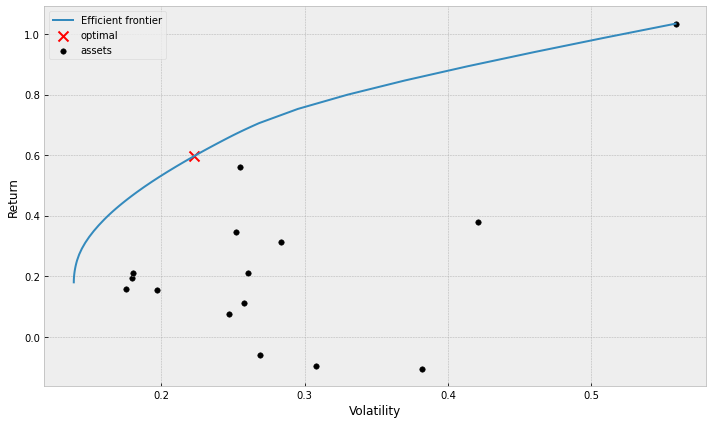

In [78]:
fig, ax = plt.subplots(figsize=(10,6))
plotting.plot_efficient_frontier(cla, ax=ax)
plt.tight_layout()
plt.show()

### Plotting - Constrained

In [79]:
import cvxpy as cp 

In [80]:
mu = expected_returns.ema_historical_return(data)
S = risk_models.CovarianceShrinkage(data).ledoit_wolf()

big_techs = [t in ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA", "NVDA"] for t in tickers]
ef = EfficientFrontier(mu, S)
ef.add_constraint(lambda w: cp.sum(w[big_techs]) <= 0.5) # sum weights of big tech <= 50%

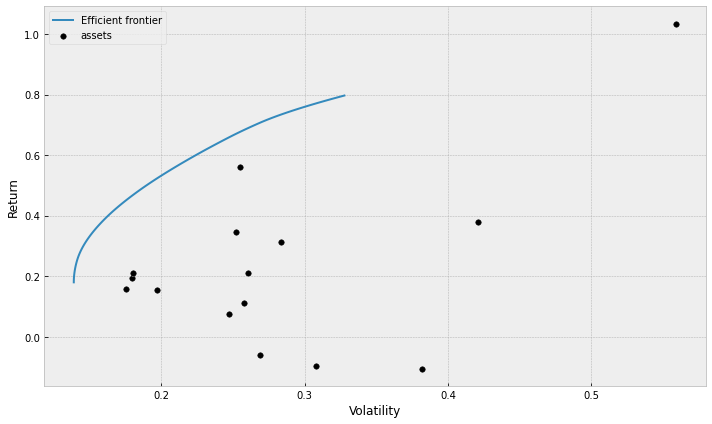

In [81]:
fig, ax = plt.subplots(figsize=(10,6))
plotting.plot_efficient_frontier(ef, ax=ax)
plt.tight_layout()
plt.show()

### Complex plots

In [82]:
# Dirichlet distribution.
# sum row == 1 --> suitable for weights --> no need to normalize
w = np.random.dirichlet((1, 1, 2), 5)
print(w.shape)
w.sum(axis=1)

(5, 3)


array([1., 1., 1., 1., 1.])

In [83]:
# random portfolio weights
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
print(w.shape)

# portfolio returns
rets = w @ mu.values
print(rets.shape)

# portfolio volatility
stds = np.sqrt(np.diag((w @ S.values) @ w.T))
print(stds.shape)

# Sharpe ratio
sharpes = rets / stds
print(sharpes.shape)

(10000, 15)
(10000,)
(10000,)
(10000,)


In [84]:
# get Max Sharpe performance
ef = EfficientFrontier(mu, S)
ef.max_sharpe()
sharpe_ret, sharpe_std, _ = ef.portfolio_performance()

# get Min Volatility performance
ef = EfficientFrontier(mu, S)
ef.min_volatility()
min_vol_ret, min_vol_std, _ = ef.portfolio_performance()

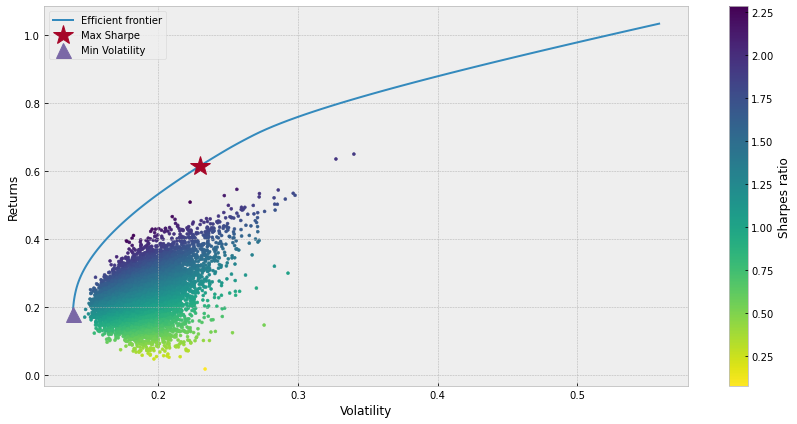

In [85]:
fig, ax = plt.subplots(figsize=(12,6))

ax0 = ax.scatter(stds, rets, marker='.', c=sharpes, cmap='viridis_r')
cbar = fig.colorbar(ax0)
cbar.ax.set_ylabel("Sharpes ratio")

ef = EfficientFrontier(mu, S)
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

ax.plot(sharpe_std, sharpe_ret, marker='*', linestyle='', markersize=20, label='Max Sharpe')
ax.plot(min_vol_std, min_vol_ret, marker='^', linestyle='', markersize=15, label='Min Volatility')

ax.legend()
ax.set_xlabel("Volatility")
ax.set_ylabel("Returns")
# ax.set_xlim(None, max(stds))
# ax.set_ylim(None, max(rets))

plt.tight_layout()
plt.show()